# Init

In [548]:
! pip install gamspy

In [549]:
! gamspy install license 204a1a5e-5e64-4583-a281-508165b2ee7e

In [550]:
import pandas as pd
from gamspy import Container, Set, Variable, Parameter, Equation, Sum, Model, Sense, Alias
import numpy as np
import itertools

# Data

In [551]:
# Load the CSV file into csv_data
csv_data = pd.read_csv("edge_distances_osrm.csv")

# Display the first few rows of the DataFrame
csv_data

,edge_name,distance_m,duration_s,from_node,to_node,distance_km,duration_min,avg_speed_kmh,u_ij,a_ij
0,E18 North,9333.6,628.5,Täby,Bergshamra,9.3336,10.475000,53.462148,2000,3.182180
1,E18 South,8989.9,704.5,Bergshamra,T-Centralen,8.9899,11.741667,45.938453,2000,2.838893
2,E20 East,8025.1,857.8,Lidingö,T-Centralen,8.0251,14.296667,33.679599,2000,2.331546
3,279 West,15364.8,1137.2,Vällingby,Bergshamra,15.3648,18.953333,48.639887,1200,1.055223
4,275 West,13454.3,1302.3,Vällingby,T-Centralen,13.4543,21.705000,37.192260,1200,0.921447
5,E20 South,8900.0,623.6,Skärholmen,Årstaberg,8.9000,10.393333,51.379089,2000,3.207184
6,75 Mid,4200.4,312.2,Årstaberg,Avicii Arena,4.2004,5.203333,48.435106,800,2.562460
7,73 South,9457.5,856.9,Farsta Shopping Centre,Avicii Arena,9.4575,14.281667,39.732758,800,0.933598
8,271 West,14464.8,1215.1,Skärholmen,Farsta Shopping Centre,14.4648,20.251667,42.855139,1200,0.987573
9,222 East,9847.3,855.9,Nacka Forum,T-Centralen,9.8473,14.265000,41.418717,1200,1.402033


### Demand split

In [552]:
# Chat Gpt generated
# Construct the DataFrame
data = {
    "Node": [
        "Farsta Shopping Centre", "Skärholmen", "Vällingby", "Täby", "Lidingö",
        "Nacka Forum", "Sollentuna", "Bergshamra", "Avicii Arena", "Årstaberg", "T-Centralen"
    ],
    "Approx. Population": [
        60_523, 33_662, 71_042, 77_744, 48_162, 110_633, 76_237, 7_300, 70_779, 12_486, 40_312
    ],
    "Source": [
        "Farsta borough (2022 estimate)",
        "Skärholmen borough (2004)",
        "Hässelby-Vällingby borough (2014)",
        "Täby Municipality (31 Dec 2024)",
        "Lidingö urban area (2023)",
        "Nacka Municipality (2023)",
        "Sollentuna Municipality (2022)",
        "Bergshamra suburb (approx.)",
        "Östermalm borough (2014)",
        "Årsta locality (recent)",
        "Norrmalm district"
    ]
}

_df = pd.DataFrame(data)


In [553]:
_init = np.diag(data["Approx. Population"])
skew = 0.9

d, _ = _init.shape

for i in range(d):
    pop = _init[i,i]
    if i != d-1:
        r_pop = int(pop*(1-skew)/(d-2))
        t_pop = pop-r_pop*(d-2)

        # Set everything to r_pop
        _init[:, i] = -r_pop

        # Restore the i-th value (keep it the same as before)
        _init[i, i] = pop

        # Set the last value to t_pop
        _init[-1, i] = -t_pop
    else:
        r_pop = int(pop/(d-1))
        t_pop = r_pop*(d-1)

        # Set everything to r_pop
        _init[:, i] = -r_pop

        # Set the last value to t_pop
        _init[-1, i] = t_pop

_init = _init.astype(int)

df_init = pd.DataFrame(_init, index=data['Node'], columns=data['Node'])

In [554]:
df_flow = df_init.melt(ignore_index=False).reset_index().rename(columns={"index": "Node", "variable": "Origin Flow", 0: "Distance"}).dropna().set_index(["Node", "Origin Flow"]).sort_index().reset_index()
df_flow.head(20)

,Node,Origin Flow,value
0,Avicii Arena,Avicii Arena,70779
1,Avicii Arena,Bergshamra,-81
2,Avicii Arena,Farsta Shopping Centre,-672
3,Avicii Arena,Lidingö,-535
4,Avicii Arena,Nacka Forum,-1229
5,Avicii Arena,Skärholmen,-374
6,Avicii Arena,Sollentuna,-847
7,Avicii Arena,T-Centralen,-4031
8,Avicii Arena,Täby,-863
9,Avicii Arena,Vällingby,-789


# Masking the Set

In [555]:
# Create all possible combinations of from_node and to_node
all_combinations = list(itertools.product(data['Node'], data['Node']))
result_df = pd.DataFrame(all_combinations, columns=['from_node', 'to_node'])

# Create a set of tuples from the original DataFrame for quick lookup
existing_pairs = set(zip(csv_data['from_node'], csv_data['to_node']))

# Add a column 'value' where 1 indicates the pair exists in csv_data, 0 otherwise
result_df['value'] = result_df.apply(lambda row: 1 if (row['from_node'], row['to_node']) in existing_pairs or (row['to_node'], row['from_node']) in existing_pairs else 0, axis=1)

# Display the resulting DataFrame
print(result_df['value'].sum())

34


# Modeling

In [556]:
m = Container()

In [557]:
on_Node = Set(m, "from_Node", records=_df["Node"].tolist())
Roads = Set(m, "Roads", records=csv_data["edge_name"].tolist())

to_Node = Alias(m, "to_Node", on_Node)
Com_from = Alias(m, "Comuter_from", on_Node)

In [558]:
Flows = Parameter(m, "flows", domain=[on_Node, Com_from], description="the flow at Node for each commuter from Nodes_", records=df_flow[["Node", "Origin Flow", "value"]])
Valid_flows = Parameter(m, "valid_flows", domain=[on_Node, to_Node], description="the allowed flow at each Node for each commuter from Nodes_", records=result_df[["from_node", "to_node", "value"]])
Road_times = Parameter(m, "road_time", domain=[on_Node, to_Node], description="Time to travel on the road", records=csv_data[["from_node", "to_node", "duration_min"]])

In [559]:
Road_in = Variable(m, "road_util1", domain=[on_Node, to_Node, Com_from], type='positive', description="Roads to be used by commuter from node")
Road_out = Variable(m, "road_util2", domain=[on_Node, to_Node, Com_from], type='positive', description="Roads to be used by commuter from node")

In [560]:
Flow_parity = Equation(m, "flow_parity", domain=[on_Node, Com_from], description="Flow parity equation")

Flow_parity[on_Node, Com_from] = (
    Sum(to_Node, Valid_flows[on_Node, to_Node]*(Road_out[on_Node, to_Node, Com_from])) - Sum(to_Node, Valid_flows[to_Node, on_Node]*(Road_in[to_Node, on_Node, Com_from])) == Flows[on_Node, Com_from]
)

In [561]:
obj = Sum((on_Node, to_Node), Road_times[on_Node, to_Node] * Sum(Com_from, Road_in[on_Node, to_Node, Com_from] + Road_out[on_Node, to_Node, Com_from]))

In [562]:
LP = Model(m, equations=m.getEquations(), sense=Sense.MIN, objective=obj, name="LP")
LP.solve()

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,7870117.85666667,122,749,MIP,CPLEX,0.001


In [563]:
Road_in.records

,from_Node,to_Node,Comuter_from,level,marginal,lower,upper,scale
0,Farsta Shopping Centre,Skärholmen,Farsta Shopping Centre,0.0,-0.000000,0.0,inf,1.0
1,Farsta Shopping Centre,Skärholmen,Skärholmen,0.0,10.393333,0.0,inf,1.0
2,Farsta Shopping Centre,Skärholmen,Vällingby,0.0,-0.000000,0.0,inf,1.0
3,Farsta Shopping Centre,Skärholmen,Täby,0.0,-0.000000,0.0,inf,1.0
4,Farsta Shopping Centre,Skärholmen,Lidingö,0.0,-0.000000,0.0,inf,1.0
...,...,...,...,...,...,...,...,...
369,T-Centralen,Avicii Arena,Sollentuna,847.0,0.000000,0.0,inf,1.0
370,T-Centralen,Avicii Arena,Bergshamra,81.0,0.000000,0.0,inf,1.0
371,T-Centralen,Avicii Arena,Avicii Arena,0.0,-0.000000,0.0,inf,1.0
372,T-Centralen,Avicii Arena,Årstaberg,138.0,0.000000,0.0,inf,1.0


# Plotting

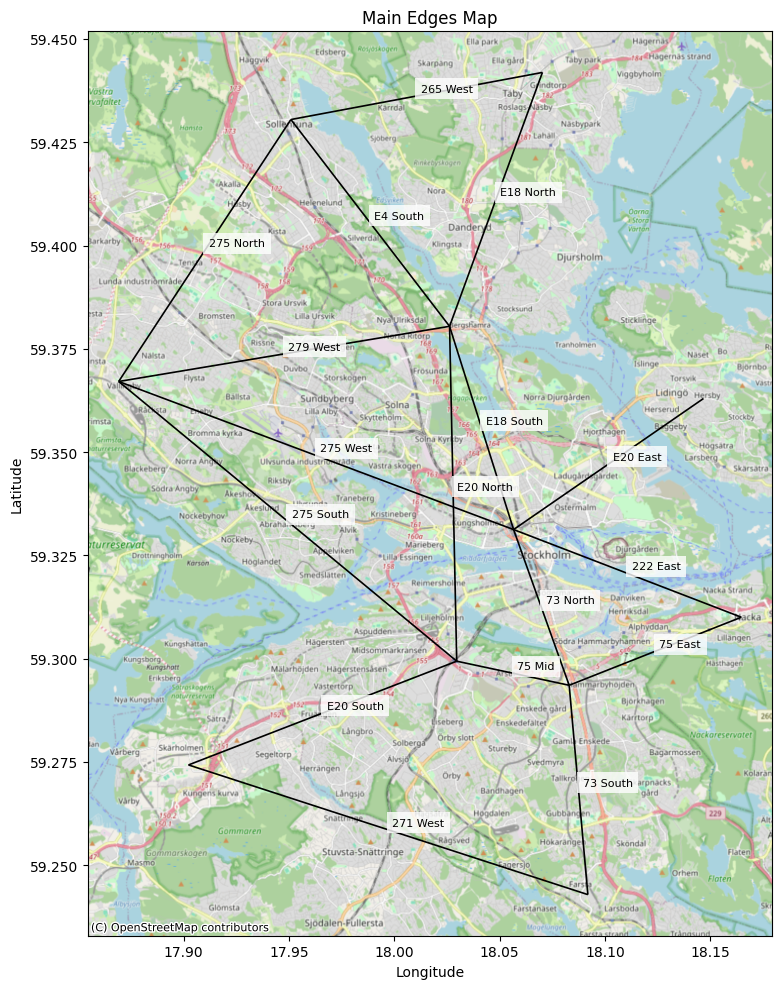

In [1]:
import geopandas as gpd
from shapely.geometry import LineString
from lxml import etree
import matplotlib.pyplot as plt
import contextily as ctx

# Parse the KML file
def parse_kml(file_path):
    with open(file_path, 'r') as f:
        tree = etree.parse(f)
    root = tree.getroot()

    # Define KML namespace
    ns = {'kml': 'http://www.opengis.net/kml/2.2'}

    # Extract placemarks
    placemarks = root.findall('.//kml:Placemark', ns)
    data = []

    for placemark in placemarks:
        name = placemark.find('kml:name', ns).text
        coords = placemark.find('.//kml:coordinates', ns).text.strip()
        # Parse coordinates into list of (lon, lat) tuples
        coord_list = []
        for coord in coords.split('\n'):
            lon, lat, _ = map(float, coord.split(','))
            coord_list.append((lon, lat))
        data.append({'name': name, 'geometry': LineString(coord_list)})

    return data

# Load KML data
file_path = 'Main Edges.kml'
data = parse_kml(file_path)

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(data, crs='EPSG:4326')

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot linestrings
gdf.plot(ax=ax, color='black', linewidth=1.2, legend=True)

# Add basemap (optional, requires contextily)
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Add labels for each linestring
for idx, row in gdf.iterrows():
    # Use the midpoint of the linestring for label placement
    midpoint = row.geometry.interpolate(0.5, normalized=True)
    ax.annotate(row['name'], xy=(midpoint.x, midpoint.y), xytext=(3, 3),
                textcoords="offset points", fontsize=8, color='black',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Set title and adjust layout
plt.title('Main Edges Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()

# Show plot
plt.show()